<a href="https://colab.research.google.com/github/iSarahSajjad/neuro-chronical-prediction/blob/Models/ChronicModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


GPU is available. Training will be performed on GPU.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.9879 - loss: 0.9210 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 3/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 4/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 5/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 6/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 7/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 8/10
434/434 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3213
Epoch 9/10
434/43

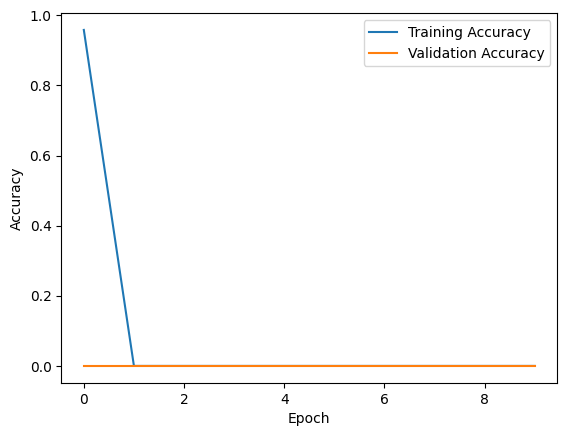

In [3]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle

# Check if GPU is available
import tensorflow as tf
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Training will be performed on GPU.")
else:
    print("GPU is not available. Training will be performed on CPU.")

# Directory where preprocessed batches are stored
batch_dir = '/content/drive/My Drive/ChronicAI/dataset/preprocessed_batches'

# Load and concatenate batch data (use a generator to avoid loading all data at once)
def batch_generator(batch_dir, batch_size=10): # Added batch size parameter
    batch_data = []
    batch_labels = []
    count = 0
    for filename in os.listdir(batch_dir):
        if filename.endswith('.pkl'):
            batch_path = os.path.join(batch_dir, filename)
            with open(batch_path, 'rb') as f:
                data, labels = pickle.load(f)
            for i in range(len(labels)):
                batch_data.append(data[i])
                batch_labels.append(labels[i])
                count += 1
                if count == batch_size:
                    yield np.array(batch_data), np.array(batch_labels)
                    batch_data = []
                    batch_labels = []
                    count = 0
    if batch_data: # Yield remaining data if any
        yield np.array(batch_data), np.array(batch_labels)

# Calculate total number of samples
num_samples = sum(len(batch_labels) for _, batch_labels in batch_generator(batch_dir))

# Split data into train and test sets (approximate split based on batch files)
train_files = os.listdir(batch_dir)[:-1]  # Use all but the last batch for training
test_files = os.listdir(batch_dir)[-1:]   # Use the last batch for testing

def train_generator(batch_size=10): # Added batch size parameter
    return batch_generator(batch_dir, batch_size) # Use the main batch generator

def test_generator(batch_size=10): # Added batch size parameter
    return batch_generator(batch_dir, batch_size) # Use the main batch generator

# Determine target shape from the first batch
first_batch_data, _ = next(train_generator(batch_size=1)) # Get only one sample
target_shape = first_batch_data.shape[1:]

# Define 3D CNN model
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=(target_shape[0], target_shape[1], target_shape[2], 1)))  # Add channel dimension
model.add(MaxPooling3D((2, 2, 2)))
model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))

# Reduce dimensionality before flattening to avoid excessive parameters in Dense layer
model.add(Conv3D(128, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D((2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 output classes

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 1 # Adjust this based on your available memory
# Note: Adjust steps_per_epoch and validation_steps based on your batch sizes and data split
history = model.fit(train_generator(batch_size=batch_size),
                    epochs=10,
                    steps_per_epoch=num_samples // batch_size, # Adjust based on your training data size
                    validation_data=test_generator(batch_size=batch_size),
                    validation_steps=len(test_files)) # Adjust based on your test data size

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
